In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
from keras_cv.models import StableDiffusion
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
import tensorflow.keras as keras

2023-05-10 18:31:14.455702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 18:31:16.552079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cudnn-8.2.4.15-11.4-eluwegpwn6adr7hlku5p5wru5xzefpop/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cuda-11.7.0-vbhdtgc7dl4kpo4auyswsh6w3udcnf5x/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/neovim-0.7.0-terkir3wk5rst6ktv4uxyaqjditacv5p/lib
2023-05-10 18:31:16.552242: W tensorflow/compiler/xla/stream_execut

2.11.0
You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/users/skoka/.venv/MLEnv3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
diffusion_model = DiffusionModel(img_width = 512, img_height = 512, max_text_length=0)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
diffusion_model.summary()

Model: "diffusion_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1280)         410880      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 activation (Activation)        (None, 1280)         0           ['dense[0][0]']                  
                                                                                    

In [4]:
diffusion_model.layers

In [5]:
cnn_layers_in_order = []

for layer in range(len(diffusion_model.layers)):
    curr_layer = diffusion_model.layers[layer]
    if len(curr_layer.get_weights()) != 0:
        for sublayer in range(len(curr_layer.get_weights())):
            shape = curr_layer.get_weights()[sublayer].shape
            if len(shape) == 4 and shape[0] == 3 and shape[1] == 3:
                cnn_layers_in_order.append((layer, sublayer))

def get_cnn_layer(index):
    return diffusion_model.layers[cnn_layers_in_order[index][0]].get_weights()[cnn_layers_in_order[index][1]]

In [6]:
for i in range(len(cnn_layers_in_order)):
    print("Layer: {}, Shape: {}".format(i, get_cnn_layer(i).shape))

Layer: 0, Shape: (3, 3, 4, 320)
Layer: 1, Shape: (3, 3, 320, 320)
Layer: 2, Shape: (3, 3, 320, 320)
Layer: 3, Shape: (3, 3, 320, 320)
Layer: 4, Shape: (3, 3, 320, 320)
Layer: 5, Shape: (3, 3, 320, 320)
Layer: 6, Shape: (3, 3, 320, 640)
Layer: 7, Shape: (3, 3, 640, 640)
Layer: 8, Shape: (3, 3, 640, 640)
Layer: 9, Shape: (3, 3, 640, 640)
Layer: 10, Shape: (3, 3, 640, 640)
Layer: 11, Shape: (3, 3, 640, 1280)
Layer: 12, Shape: (3, 3, 1280, 1280)
Layer: 13, Shape: (3, 3, 1280, 1280)
Layer: 14, Shape: (3, 3, 1280, 1280)
Layer: 15, Shape: (3, 3, 1280, 1280)
Layer: 16, Shape: (3, 3, 1280, 1280)
Layer: 17, Shape: (3, 3, 1280, 1280)
Layer: 18, Shape: (3, 3, 1280, 1280)
Layer: 19, Shape: (3, 3, 1280, 1280)
Layer: 20, Shape: (3, 3, 1280, 1280)
Layer: 21, Shape: (3, 3, 1280, 1280)
Layer: 22, Shape: (3, 3, 1280, 1280)
Layer: 23, Shape: (3, 3, 1280, 1280)
Layer: 24, Shape: (3, 3, 2560, 1280)
Layer: 25, Shape: (3, 3, 1280, 1280)
Layer: 26, Shape: (3, 3, 2560, 1280)
Layer: 27, Shape: (3, 3, 1280, 1280)

In [ ]:
def perform_branch_svd(layer_n, layer_n_plus_1):
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
  
    # how we adjust for concatenations in the u-net
    weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]

    # Perform SVD on the signed values of the weights between layers n and n+1
    signed_weights_n = weights_n.reshape(weights_n.shape[-1], -1)
    signed_weights_n_plus_1 = weights_n_plus_1.reshape(weights_n_plus_1.shape[-1], -1)
    abs_weights_n = np.abs(weights_n.reshape(weights_n.shape[-1], -1))
    abs_weights_n_plus_1 = np.abs(weights_n_plus_1.reshape(weights_n_plus_1.shape[-1], -1))
    u, s, vt = np.linalg.svd(abs_weights_n_plus_1, full_matrices=True)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.xlabel('Singular Vector 0')
    plt.ylabel('Singular Vector 1')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.xlabel('Singular Vector 0')
    plt.ylabel('Singular Vector 1')

    plt.show()


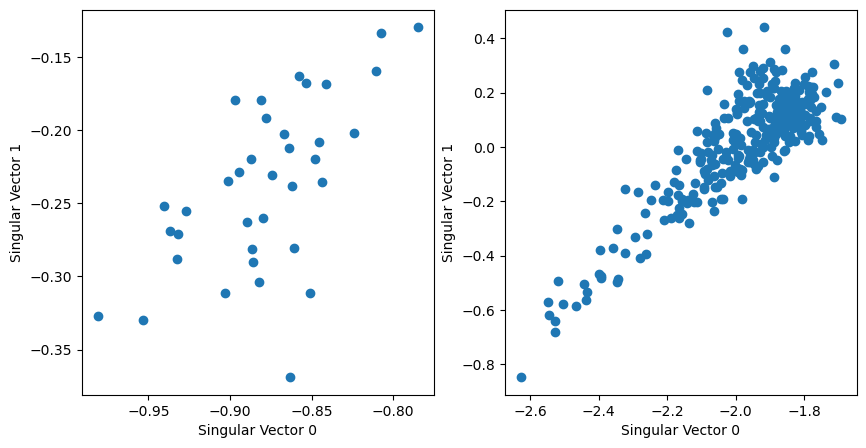

In [ ]:
perform_branch_svd(0, 1)

In [21]:
def adaptive_branch_svd(layer_n, layer_n_plus_1):
    # This code will still work as before, but now we can also plot layers where the number of filters changes between layers n and n+1
    # but the interpretation of the second plot in that case is different (how channels connect in the second layer to the first layer)
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
  
    # how we adjust for concatenations in the u-net
    weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]

    # Perform SVD on the abs values of the weights between layers n and n+1
    abs_weights_n = np.abs(weights_n.reshape(weights_n.shape[-1], -1))
    abs_weights_n_plus_1 = np.abs(weights_n_plus_1.reshape(weights_n_plus_1.shape[-2], -1))
    u, s, vt = np.linalg.svd(abs_weights_n_plus_1, full_matrices=True)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n
    print(abs_weights_n.shape)
    print(layer_n_proj.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    #plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.scatter(layer_n_proj[1, :], layer_n_proj[0, :])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    #plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.scatter(layer_n_plus_1_proj[:, 1], layer_n_plus_1_proj[:, 0])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    plt.show()




(320, 36)
(2, 36)


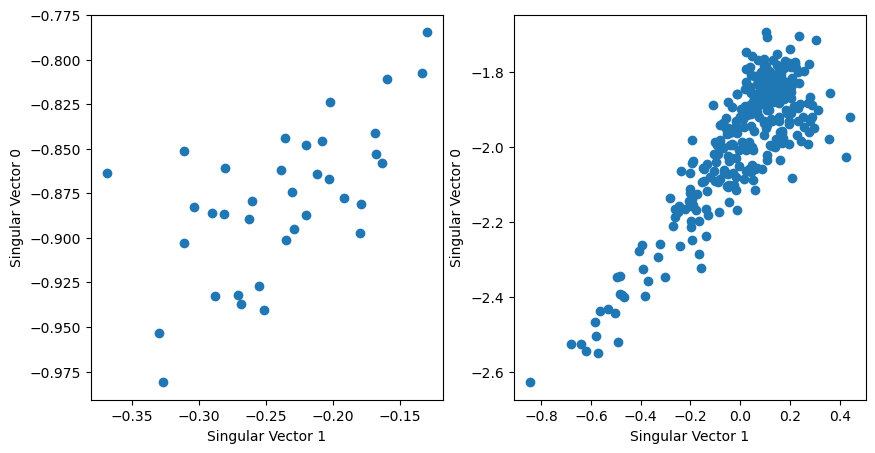

In [22]:
adaptive_branch_svd(0, 1)

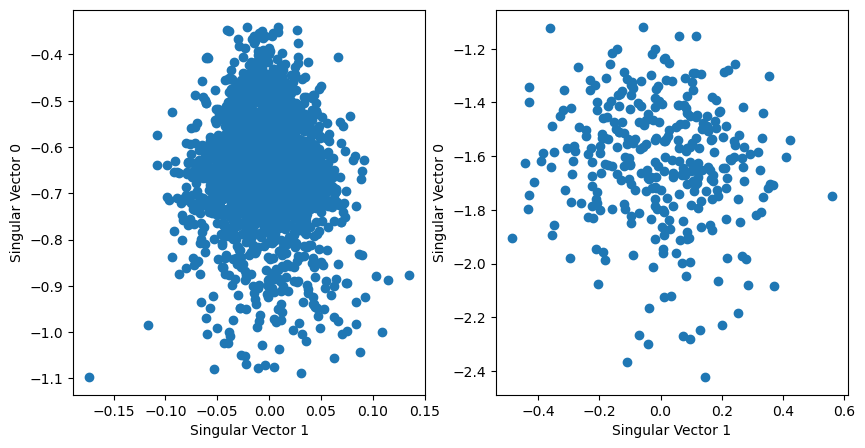

In [20]:
adaptive_branch_svd(1, 2)

In [7]:
def visualize_branch_svd_combined(layer_n, layer_n_plus_1, concat=False):
    # This code will still work as before, but now we can also plot layers where the number of filters changes between layers n and n+1
    # but the interpretation of the second plot in that case is different (how channels connect in the second layer to the first layer)
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
    # store the number of chhannels in layer n+1
    # how we adjust for concatenations in the u-net
    if concat:
        weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]
    else:
         weights_n_plus_1 = weights_n_plus_1[:, :, :weights_n.shape[-1], :]

    # Perform SVD on the abs values of the weights between layers n and n+1
    weights_n = weights_n.reshape(weights_n.shape[-1], -1)
    abs_weights_n = np.abs(weights_n)
    weights_n_plus_1 = weights_n_plus_1.reshape(weights_n_plus_1.shape[-2], -1)
    abs_weights_n_plus_1 = np.abs(weights_n_plus_1)
    weights_between = weights_n.T @ weights_n_plus_1
    abs_weights_between = np.abs(weights_between)
    u, s, vt = np.linalg.svd(abs_weights_between, full_matrices=True)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n.T
    print("here")
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    #plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.scatter(layer_n_proj[1, :], layer_n_proj[0, :])
    # label the points
    for i in range(layer_n_proj.shape[1]):
         plt.annotate(str(i), (layer_n_proj[1, i], layer_n_proj[0, i]))
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    #plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.scatter(layer_n_plus_1_proj[:, 1], layer_n_plus_1_proj[:, 0])
    # label the points
    for i in range(layer_n_plus_1_proj.shape[0]):
         plt.annotate(str(i), (layer_n_plus_1_proj[i, 1], layer_n_plus_1_proj[i, 0]))
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    return plt


here


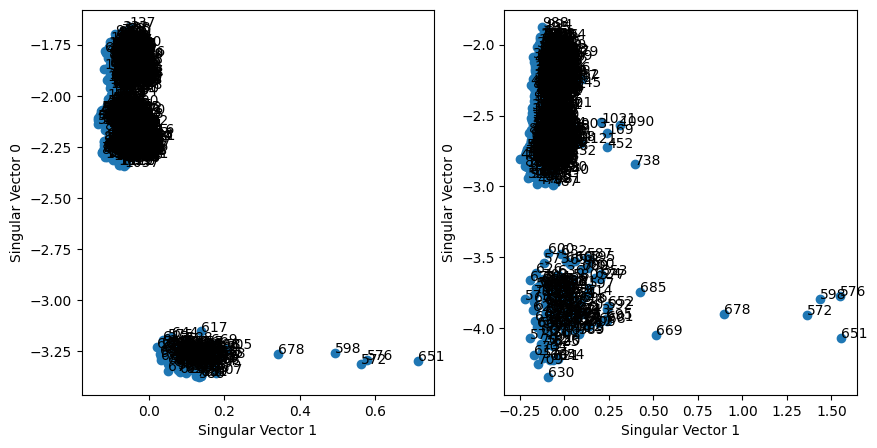

In [8]:
plot = visualize_branch_svd_combined(37, 38, concat=False)

In [11]:
cnn_layers_in_order[9]

(14, 8)

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [49]:
import tensorflow as tf
import os
import tensorflow as tf
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
tf.print("Matrix multiplication result:", c)


Matrix multiplication result: [[22 28]
 [49 64]]


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

def visualize_branch_svd_combined_tf(layer_n, layer_n_plus_1, concat=False):
    with tf.device('/GPU:0'):
        weights_n = get_cnn_layer(layer_n)
        weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)

        if concat:
            weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]
        else:
            weights_n_plus_1 = weights_n_plus_1[:, :, :weights_n.shape[-1], :]
        weights_n = tf.reshape(weights_n, (weights_n.shape[-1], -1))
        abs_weights_n = tf.abs(weights_n)

        weights_n_plus_1 = tf.reshape(weights_n_plus_1, (weights_n_plus_1.shape[-2], -1))
        abs_weights_n_plus_1 = tf.abs(weights_n_plus_1)

        weights_between = tf.linalg.matmul(tf.transpose(abs_weights_n), abs_weights_n_plus_1)
        abs_weights_between = tf.abs(weights_between)
        s, u, v = tf.linalg.svd(abs_weights_between, full_matrices=True)
        layer_n_proj = tf.linalg.matmul(tf.transpose(u[:, :2]), tf.transpose(abs_weights_n))
        layer_n_proj = layer_n_proj.numpy()  # Convert to numpy after the computation

        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.scatter(layer_n_proj[1, :], layer_n_proj[0, :])
        for i in range(layer_n_proj.shape[1]):
            plt.annotate(str(i), (layer_n_proj[1, i], layer_n_proj[0, i]))
        plt.xlabel('Singular Vector 1')
        plt.ylabel('Singular Vector 0')



        layer_n_plus_1_proj = tf.linalg.matmul(abs_weights_n_plus_1, v[:, :2])
        layer_n_plus_1_proj = layer_n_plus_1_proj.numpy()  # Convert to numpy after the computation

        plt.subplot(122)
        plt.scatter(layer_n_plus_1_proj[:, 1], layer_n_plus_1_proj[:, 0])
        for i in range(layer_n_plus_1_proj.shape[0]):
            plt.annotate(str(i), (layer_n_plus_1_proj[i, 1], layer_n_plus_1_proj[i, 0]))
        plt.xlabel('Singular Vector 1')
        plt.ylabel('Singular Vector 0')

        plt.show()




In [7]:
visualize_branch_svd_combined_tf(9, 38, concat=True)

NameError: name 'visualize_branch_svd_combined_tf' is not defined